In [1]:
# version thu 19:22

In [16]:
import tensorflow as tf
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import sys
import random

random.seed(111)

In [17]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # cuts off tails from normal distribution, keeps elements [-2,2] #
    return tf.Variable(initial)

##### ----- Import data ---- #####
configs = np.load('/Users/tibraali/Documents/Machine_Learning_Winter_School/Python_Codes/Data Sets/configs.npy')
num_configs = len(configs)
labels = np.empty([num_configs,2])
labels[:,0] = np.load('/Users/tibraali/Documents/Machine_Learning_Winter_School/Python_Codes/Data Sets/labels.npy')

In [18]:
# convert labels into 1-hot representation
# y=0 --> (1,0)
# y=1 --> (0,1)
ind0 = (labels[:,0]==0)
ind1 = (labels[:,0]==1)
labels[ind0,:]=np.array([1,0])
labels[ind1,:]=np.array([0,1])
    
##### ----- Select training and test set ---- #####
# we choose the training set to be about 85% of the entire data set
num_train_configs = 3400
train_indices = random.sample(range(num_configs),num_train_configs)
test_indices = [ x for x in range(num_configs) if x not in train_indices]
    
configs_train = np.array( [configs[i] for i in train_indices] )
configs_test = np.array( [configs[i] for i in test_indices] )
labels_train = np.array( [labels[i] for i in train_indices] )
labels_test = np.array( [labels[i] for i in test_indices] )

In [ ]:
##### ----- Create the model ---- #####
    
n_units = [12,10,7,5,4,3,2] # number of units in each layer, starting from the input layer
num_layers = len(n_units)

x = tf.placeholder(tf.float32, [None, n_units[0]])
W   = [None for i in range(num_layers-1)]
b   = [None for i in range(num_layers-1)]
out = [None for i in range(num_layers-2)]

for i in range(len(W)):
    W[i] = tf.Variable(tf.truncated_normal([n_units[i], n_units[i+1]], stddev=0.1))
    b[i] = tf.Variable(tf.truncated_normal([n_units[i+1]], stddev=0.1))

    if i==0: #first layer
        out[i] = tf.tanh( tf.matmul(x, W[i]) + b[i] )
    elif i<(len(W)-1):
        out[i] = tf.tanh( tf.matmul(out[i-1], W[i]) + b[i] )
    else: #output layer
        y = tf.matmul(out[i-1], W[i])+b[i]
    
# define loss and optimizer
y_ = tf.placeholder(tf.float32,[None,2])

cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))  # Calculate the cross entropy (this tells us whether our network is actually learning)#
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# instructions on how to train our model
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.2
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.96, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

# begin training sessions
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# define functions for testing of the trained model
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# training parameters
minibatch_size = 100     # "batching" the configuration is what introduces stochasticity into the network (this is a must!)#
num_epochs = 10000        # how many times do we run through the process and let our network learn

# define arrays to collect accuracy and error data during training
err_list  = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = []

# add ops to save and restore all the variables
saver = tf.train.Saver(max_to_keep=num_epochs)

# reshuffle the data set in each epoch
permut = np.arange(num_train_configs)
    
for epoch in range(num_epochs):
    print(epoch)
    # save the variables to disk
    save_path = saver.save(sess,"/Users/tibraali/Documents/Machine_Learning_Winter_School/Python_Codes/Data/toy_network_model_{}.ckpt".format(epoch))
    #print("Model saved in file: /toy_network_model_{}.ckpt".format(epoch))
    #print("Model saved in file: %s" % save_path)
    np.random.shuffle(permut)
    train_configs = configs_train[permut,:]
    train_labels = labels_train[permut,:]
    for k in range(0, num_train_configs, minibatch_size):
        batch_xs = train_configs[k:k+minibatch_size,:]
        batch_ys = train_labels[k:k+minibatch_size,:]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        # for each epoch record one value of training accuracy and cross entropy
        if k==minibatch_size:
            train_acc[epoch] = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})   
            err_list[epoch] = sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys})
    # for every 10th epoch record the test accuracy
    if epoch%10==0:
        test_acc += [sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test})]

# save arrays with accuracy and error data
np.savez_compressed('{}epochs_train_acc'.format(num_epochs), a=train_acc)
np.savez_compressed('{}epochs_test_acc'.format(num_epochs), a=test_acc)
np.savez_compressed('{}epochs_err_list'.format(num_epochs), a=err_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

minibatch size = 100
number of epoches = 5000
test accuracy final epoch = 0.715517


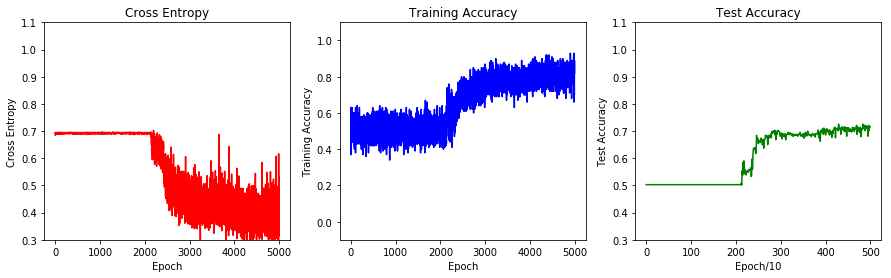

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the data
err_list = np.load('{}epochs_err_list.npz'.format(num_epochs))['a']
train_acc = np.load('{}epochs_train_acc.npz'.format(num_epochs))['a']
test_acc = np.load('{}epochs_test_acc.npz'.format(num_epochs))['a']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(np.arange(num_epochs), err_list, color='r')
plt.title('Cross Entropy')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0.3, 1.1])


plt.subplot(1,3,2)
plt.plot(np.arange(num_epochs), train_acc, color='b')
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.plot(np.arange(num_epochs/10), test_acc, color='g')
plt.title('Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch/10')
plt.ylim([0.3, 1.1])

print("minibatch size = %d" %minibatch_size)
print("number of epoches = %d" %num_epochs)
print("test accuracy final epoch = %f" %test_acc[-1])

In [42]:
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test}))

0.71408045
